# Deep Convolutional Generative Adversarial Networks

In [1]:
import time
import zipfile
import pickle
from pathlib import Path
from tempfile import NamedTemporaryFile, TemporaryDirectory
import numpy as np
import functools as ft

import mlx.optimizers as optim
import mlx.nn as nn
import mlx.core as mx
import mlx.data as dx
from mlx.data.datasets.common import CACHE_DIR, ensure_exists, urlretrieve_with_progress

from PIL import Image

# Constants

In [ ]:
BATCH_SIZE = 128
NUM_EPOCHS = 100
Z_DIM = 100
IMAGE_SHAPE = (64, 64, 1)
IMAGE_DIR = Path("./images"); ensure_exists(IMAGE_DIR)
SAVE_EVERY_EPOCH = 5

In [3]:
mx.random.seed(0)

# Dataset

In [4]:
def _load_lego_bricks_wrapper(root=None):
    base_url = "https://www.kaggle.com/api/v1/datasets/download/joosthazelzet/lego-brick-images"

    if root is None:
        root = CACHE_DIR / "lego_brick_images"
    else:
        root = Path(root)
    ensure_exists(root)

    pkl_file = root / "lego_brick_images.pkl"

    def download():

        temp_file = NamedTemporaryFile()
        urlretrieve_with_progress(src=base_url, dst=temp_file.name)

        temp_dir = TemporaryDirectory()
        with zipfile.ZipFile(temp_file.name, 'r') as zf:
            zf.extractall(temp_dir.name)
            image_dir = Path(temp_dir.name) / "dataset"
            images = [
                {"image": np.array(Image.open(fname)\
                                        .convert('L')\
                                        .resize(size=(64, 64), resample=Image.BILINEAR))
                }
                for fname in image_dir.glob("*.png")
            ]

        with pkl_file.open("wb") as f:
            pickle.dump(images, f)

    if not pkl_file.is_file():
        download()

    with pkl_file.open("rb") as f:
        return dx.buffer_from_vector(pickle.load(f))


def load_lego_bricks(root=None):
    """Load a buffer with the Lego Bricks dataset.

    If the data doesn't exist download it and save it for the next time.
    Because the dataset is relatively small (40_000 samples), it is prepared
    as a pickled Numpy array.

    The dataset has no labels, and loaded as grayscale images of size 64x64

    Args:
        root (Path or str, optional): The directory to load/save the data. If
            none is given the ``~/.cache/mlx.data/lego_brick_images`` is used.
    """

    return _load_lego_bricks_wrapper(root)

In [5]:
def get_lego_bricks(batch_size, root=None):

    def normalize(x):
        return (x[..., None].astype("float32") - 127.5) / 127.5

    return (
        load_lego_bricks(root)
        .shuffle()
        .to_stream()
        .key_transform("image", normalize)
        .batch(batch_size)
        .prefetch(prefetch_size=8, num_threads=8)
    )

data = get_lego_bricks(batch_size=BATCH_SIZE)

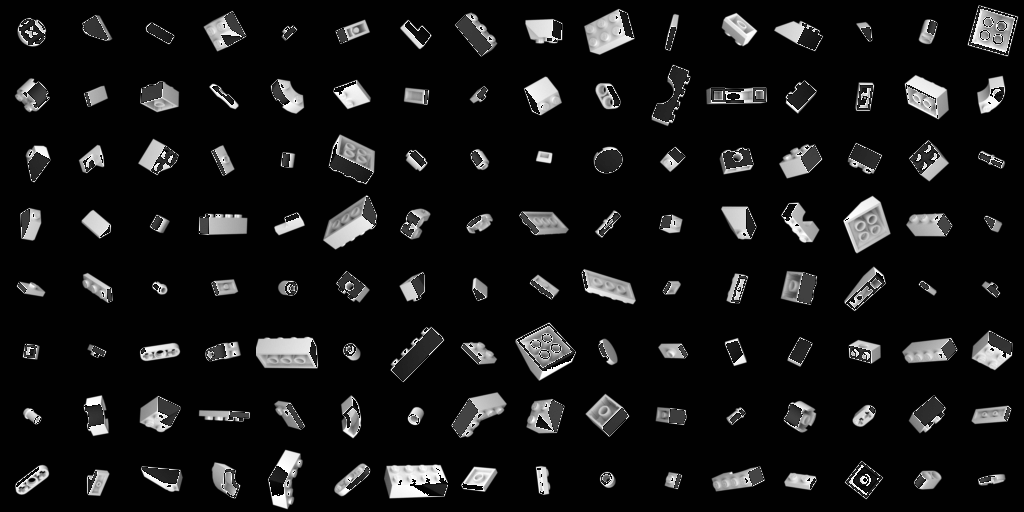

In [6]:
def grid_image_from_batch(image_batch, num_rows):
    """
    Generate a grid image from a batch of images.
    Assumes input has shape (B, H, W, C).
    """

    B, H, W, _ = image_batch.shape

    num_cols = B // num_rows

    # Calculate the size of the output grid image
    grid_height = num_rows * H
    grid_width = num_cols * W

    # Normalize and convert to the desired data type
    image_batch = np.array(image_batch * 255).astype(np.uint8)

    # Reshape the batch of images into a 2D grid
    grid_image = image_batch.reshape(num_rows, num_cols, H, W, -1)
    grid_image = grid_image.swapaxes(1, 2)
    grid_image = grid_image.reshape(grid_height, grid_width, -1)

    # Convert the grid to a PIL Image
    return Image.fromarray(grid_image.squeeze())

samples = next(data)["image"]
grid_image_from_batch(samples, num_rows=8)

# The Discriminator

In [7]:
class Discriminator(nn.Module):

    def __init__(self, input_dim: int, output_dim: int):

        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=input_dim, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm(num_features=64, momentum=0.9),
            ft.partial(nn.leaky_relu, negative_slope=0.2),
            nn.Dropout(p=0.3),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm(num_features=128, momentum=0.9),
            ft.partial(nn.leaky_relu, negative_slope=0.2),
            nn.Dropout(p=0.3),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm(num_features=256, momentum=0.9),
            ft.partial(nn.leaky_relu, negative_slope=0.2),
            nn.Dropout(p=0.3),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm(num_features=512, momentum=0.9),
            ft.partial(nn.leaky_relu, negative_slope=0.2),
            nn.Dropout(p=0.3),
            nn.Conv2d(in_channels=512, out_channels=output_dim, kernel_size=4, stride=1, padding=0, bias=False),
            lambda x: x.reshape(x.shape[0], -1),
        )

    def __call__(self, x: mx.array) -> mx.array:
        return self.net(x)

In [8]:
# model_d = Discriminator(input_dim=1, output_dim=1)
# mx.eval(model_d.parameters())
# model_d(mx.ones(shape=(128, 64, 64, 1))).shape

# The Generator

In [9]:
class Generator(nn.Module):

    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            lambda x: x.reshape(-1, 1, 1, input_dim),
            nn.ConvTranspose2d(in_channels=input_dim, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm(num_features=512, momentum=0.9),
            ft.partial(nn.leaky_relu, negative_slope=0.2),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm(num_features=256, momentum=0.9),
            ft.partial(nn.leaky_relu, negative_slope=0.2),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm(num_features=128, momentum=0.9),
            ft.partial(nn.leaky_relu, negative_slope=0.2),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm(num_features=64, momentum=0.9),
            ft.partial(nn.leaky_relu, negative_slope=0.2),
            nn.ConvTranspose2d(in_channels=64, out_channels=output_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def __call__(self, x: mx.array) -> mx.array:
        return self.net(x)

In [10]:
# model_g = Generator(input_dim=100, output_dim=1)
# mx.eval(model_g.parameters())
# model_g(mx.ones(shape=(128, 100))).shape

# Loss

In [11]:
def loss_fn_d(model_g, model_d, x, z_dim):
    batch_size = x.shape[0]

    #  Discriminate fake images as fake
    fake_labels = mx.zeros(shape=(batch_size, 1))
    fake_noisy_labels = fake_labels + 0.1 * mx.random.uniform(shape=(batch_size, 1))  # label smoothing
    z = mx.random.normal(shape=(batch_size, z_dim))
    fake_loss = nn.losses.binary_cross_entropy(model_d(model_g(z)), fake_noisy_labels)

    # Discriminate real images as real
    real_labels = mx.ones(shape=(batch_size, 1))
    real_noisy_labels = real_labels - 0.1 * mx.random.uniform(shape=(batch_size, 1))  # label smoothing
    real_loss = nn.losses.binary_cross_entropy(model_d(x), real_noisy_labels)

    loss = (fake_loss + real_loss) / 2.0

    return loss


def loss_fn_g(model_g, model_d, batch_size, z_dim):
    """Generator loss"""

    # Classify generated images as real
    real_labels = mx.ones(shape=(batch_size, 1))
    real_noisy_labels = real_labels - 0.1 * mx.random.uniform(shape=(batch_size, 1))  # label smoothing

    z = mx.random.normal(shape=(batch_size, z_dim))
    loss = nn.losses.binary_cross_entropy(model_d(model_g(z)), real_noisy_labels)  # with_logits = True

    return loss

In [ ]:
model_d = Discriminator(input_dim=IMAGE_SHAPE[-1], output_dim=1)
model_g = Generator(input_dim=Z_DIM, output_dim=IMAGE_SHAPE[-1])

mx.eval(model_d.parameters())
mx.eval(model_g.parameters())

optimizer_g = optim.AdamW(learning_rate=5e-5, betas=[0.5, 0.999], weight_decay=0.01)
optimizer_d = optim.AdamW(learning_rate=1e-4, betas=[0.5, 0.999], weight_decay=0.01)

In [13]:
def train_epoch(model_d, model_g, optimizer_d, optimizer_g, data, epoch):

    losses = {"discriminator": [], "generator": []}
    samples_per_sec = []

    # Using mx.random.state as the Discriminator is using Dropout
    state = [model_d.state, model_g.state, optimizer_d.state, optimizer_g.state, mx.random.state]

    @ft.partial(mx.compile, inputs=state, outputs=state)
    def step(x):
        loss_and_grad_fn_g = nn.value_and_grad(model_g, loss_fn_g)
        loss_and_grad_fn_d = nn.value_and_grad(model_d, loss_fn_d)
        # train discriminator
        loss_d, grads_d = loss_and_grad_fn_d(model_g, model_d, x, Z_DIM)
        optimizer_d.update(model_d, grads_d)
        # train generator
        loss_g, grads_g = loss_and_grad_fn_g(model_g, model_d, BATCH_SIZE, Z_DIM)
        optimizer_g.update(model_g, grads_g)
        return loss_d, loss_g

    for batch_counter, batch in enumerate(data):

        x = mx.array(batch["image"])

        tic = time.perf_counter()
        loss_d, loss_g = step(x)
        mx.eval(state)
        toc = time.perf_counter()

        losses["discriminator"].append(loss_d.item())
        losses["generator"].append(loss_g.item())

        throughput = x.shape[0] / (toc - tic)
        samples_per_sec.append(throughput)
        if batch_counter % 10 == 0:
            print(
                " | ".join(
                    (
                        f"Epoch {epoch:02d} [{batch_counter:03d}]",
                        f"Discriminator Loss {loss_d:.3f}",
                        f"Generator loss {loss_g:.3f}",
                        f"Throughput: {throughput:.2f} images/second",
                    )
                )
            )

    mean_loss_d = mx.mean(mx.array(losses["discriminator"]))
    mean_loss_g = mx.mean(mx.array(losses["generator"]))
    samples_per_sec = mx.mean(mx.array(samples_per_sec))

    return mean_loss_d, mean_loss_g, samples_per_sec


In [ ]:
metrics_history = {
    "loss_d": [],
    "loss_g": [],
    "throughput": [],
}

for epoch in range(NUM_EPOCHS):

    data.reset()

    loss_d, loss_g, throughput = train_epoch(model_d, model_g, optimizer_d, optimizer_g, data, epoch)

    metrics_history["loss_d"].append(loss_d)
    metrics_history["loss_g"].append(loss_g)
    metrics_history["throughput"].append(throughput)

    print("-"*100)
    print(
        " | ".join(
            (
                f"avg. Train loss discriminator {loss_d.item():.3f}",
                f"avg. Train loss generator {loss_g.item():.3f}",
                f"Throughput: {throughput.item():.2f} images/sec",
            )
        )
    )
    print("-"*100)

    # plot some samples after save_interval epochs
    if epoch % SAVE_EVERY_EPOCH == 0 or epoch == (NUM_EPOCHS - 1):
        z = mx.random.normal(shape=(BATCH_SIZE, Z_DIM))  # 128 random vectors
        fake_images = mx.array(model_g(z))
        img = grid_image_from_batch(fake_images, num_rows=8)

        img.save(f"./images/image_{epoch}.png")

Epoch 00 [000] | Discriminator Loss 0.697 | Generator loss 4.341 | Throughput: 416.45 images/second
Epoch 00 [010] | Discriminator Loss 0.328 | Generator loss 3.608 | Throughput: 620.33 images/second
Epoch 00 [020] | Discriminator Loss 0.230 | Generator loss 3.850 | Throughput: 620.14 images/second
Epoch 00 [030] | Discriminator Loss 1.078 | Generator loss 2.877 | Throughput: 619.05 images/second
Epoch 00 [040] | Discriminator Loss 0.281 | Generator loss 2.022 | Throughput: 621.74 images/second
Epoch 00 [050] | Discriminator Loss 0.257 | Generator loss 1.973 | Throughput: 618.72 images/second
Epoch 00 [060] | Discriminator Loss 0.277 | Generator loss 2.566 | Throughput: 621.67 images/second
Epoch 00 [070] | Discriminator Loss 0.329 | Generator loss 3.842 | Throughput: 620.76 images/second
Epoch 00 [080] | Discriminator Loss 0.353 | Generator loss 2.205 | Throughput: 621.79 images/second
Epoch 00 [090] | Discriminator Loss 0.460 | Generator loss 1.146 | Throughput: 623.09 images/second


# Visualize the metrics

/var/folders/1y/ss_yfq694jj6ylk_kr7v1b580000gn/T/ipykernel_85083/1459046709.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/var/folders/1y/ss_yfq694jj6ylk_kr7v1b580000gn/T/ipykernel_85083/1459046709.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


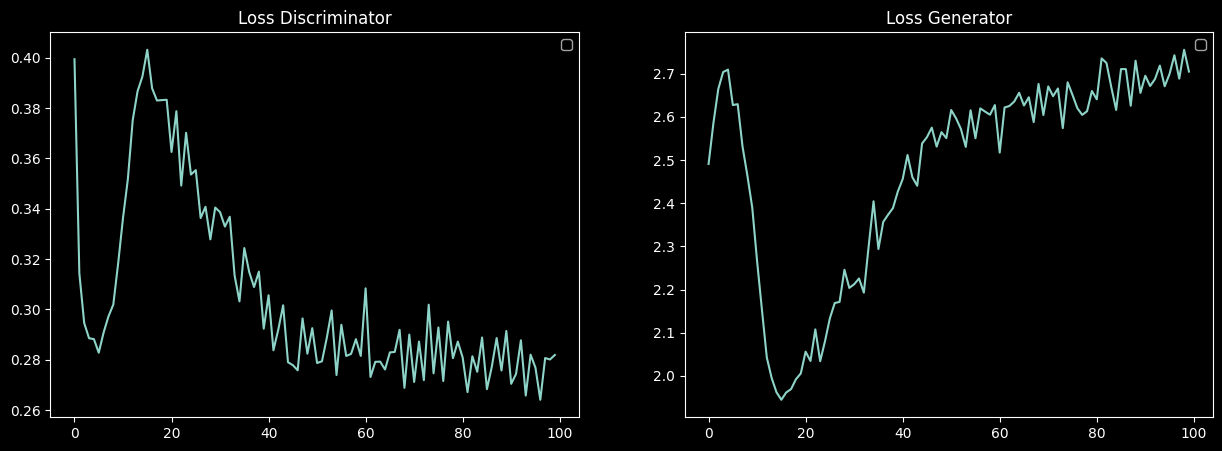

In [15]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Loss Discriminator")
ax2.set_title("Loss Generator")
ax1.plot(metrics_history["loss_d"])
ax2.plot(metrics_history["loss_g"])
ax1.legend()
ax2.legend()
plt.show()